<a href="https://colab.research.google.com/github/podo1skii/spbu_cldocs/blob/master/Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

url_entrypoint_host = 'http://notelections.online/region/'
url = 'region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222'

In [12]:
def parse_header_row(row):
  result = []
  columns = row.findAll('td')
  for column in columns:
    result.append(column.find('a').text)
  return result

def parse_value(value):
  return re.search(r'\d+', value).group(0)

In [13]:
def parse_endpoint(url, tik):
  r = requests.get(url_entrypoint_host + url)
  soup = BeautifulSoup(r.text)
  table = soup.find_all('table')
  rows = table[-1].findAll('tr')
  header_rows = parse_header_row(rows[0])

  other_table = []
  for row in rows[1:]:
    try:
      current_row = []
      columns = row.findAll('td')
      for column in columns:
        current_row.append(parse_value(column.text))
      other_table.append(current_row)
    except: 
      pass
  
  num = re.findall(r'\d+', tik)
  data = pd.DataFrame(other_table).transpose()
  data['ТИК'] = [int(num[0]) if num else None for i in range(len(header_rows))]
  data['УИК'] = [int(re.findall(r'\d+', header_rows[i])[0]) for i in range(len(header_rows))]
  return data

In [14]:
r = requests.get(url_entrypoint_host + url)
soup = BeautifulSoup(r.text)

links=soup.find_all('a', href=True)

table = []

for i in links:
  if i['href'].startswith('/region/region/st-petersburg'):
    table_slice = parse_endpoint(i['href'], i.text)
    table.append(table_slice)

table = pd.concat(table, ignore_index=True, sort=False)
table = table.drop(index=2021)




### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [15]:
table = table.rename(columns={0: 'total', 1: 'bulls', 2: 'some', 3:'name', 4: 'canceled', 5: 'for', 6: 'colums', 7: 'too',\
                              8: 'complex', 9: 'names', 10: 'in', 11: 'cand1', 12: 'cand2', 13: 'cand3'})
table = table.apply(pd.to_numeric)
table

,total,bulls,some,name,canceled,for,colums,too,complex,names,in,cand1,cand2,cand3,ТИК,УИК
0,1803,1200,587,11,602,11,587,23,575,0,0,110,345,120,1,1
1,1466,1100,433,14,653,14,430,19,425,0,0,53,326,46,1,2
2,2092,1600,576,22,1002,22,576,15,583,0,0,155,332,96,1,3
3,1056,1000,318,4,678,4,318,13,309,0,0,67,171,71,1,4
4,1827,1400,495,8,897,8,493,16,485,0,0,137,266,82,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,284,300,166,53,81,53,166,0,219,0,0,21,184,14,30,2350
2017,132,150,86,27,37,27,86,2,111,0,0,7,91,13,30,2351
2018,320,350,217,23,110,23,217,4,236,0,0,20,193,23,30,2352
2019,485,500,335,12,153,12,335,2,345,0,0,23,290,32,30,2355


<h1> Задаине 1 </h1>

In [ ]:
new = table.groupby(['ТИК'])['total', 'complex'].sum()
res = new['complex'] / new['total'] * 100
res.sort_values(ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


ТИК
18    49.598661
15    38.887784
13    38.486081
19    37.260688
8     34.695419
20    32.697353
9     32.533716
22    31.489071
30    30.952381
2     30.737680
1     30.145958
10    29.746707
4     29.464766
29    29.378246
21    28.418639
7     28.200960
25    28.113792
17    27.428579
16    27.125936
14    26.581870
28    26.580176
23    26.487978
11    26.015432
5     25.982522
24    25.907143
3     25.646168
12    25.609325
26    25.457989
6     24.346173
27    23.988446
dtype: float64

<h1> Задание 2 </h2>

In [ ]:
new = table[table['complex'] >= 100]
new = new['cand2'] / new['complex']
table.loc[[new.idxmax()]]

,total,bulls,some,name,canceled,for,colums,too,complex,names,in,cand1,cand2,cand3,ТИК,УИК,turn,cand2 _pers
1453,668,1000,68,600,332,600,68,3,665,0,0,6,652,7,22,403,10.179641,959.0


<h1> Задание 3 </h2>

In [ ]:
table['turn'] = table['complex'] / table['total'] * 100
max = table.groupby(['ТИК'])['turn'].max()
min = table.groupby(['ТИК'])['turn'].min()
diff = max - min
diff.loc[[diff.idxmax()]]

ТИК
11    80.751999
Name: turn, dtype: float64

<h1> Задание 4 </h1>

In [ ]:
var = table.groupby(['ТИК'])['turn'].var()
var

ТИК
1     188.133458
2     456.180020
3      69.108981
4     221.862618
5     131.018165
6      18.510552
7      63.873858
8     222.281371
9     112.210987
10     74.900375
11    234.094658
12     31.018136
13    370.817654
14     29.995824
15    383.830541
16    102.581810
17    313.288501
18    238.953822
19    207.825797
20    164.346682
21    301.413929
22    416.765838
23    577.819994
24    263.010286
25      8.043611
26    192.770708
27    187.488823
28    369.688448
29    235.520634
30    500.703138
Name: turn, dtype: float64

<h1> Задание 5 </h1>

In [ ]:
table['cand2 _pers'] = (table['cand2'] / table['complex'] * 100).round(0)
res = table.groupby("cand2 _pers").count()['УИК']
res

cand2 _pers
31.0    1
32.0    1
34.0    2
39.0    3
40.0    1
       ..
93.0    1
94.0    2
95.0    5
96.0    1
98.0    4
Name: УИК, Length: 62, dtype: int64

<h1> Задание 6 </h1>

Text(0, 0.5, 'Процент голосов за Беглова')

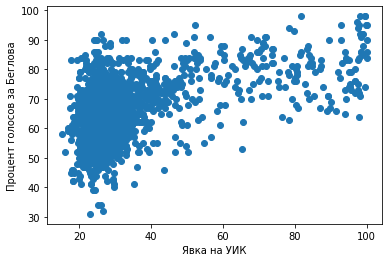

In [ ]:
plt.scatter(table['turn'], table['cand2 _pers'])
plt.xlabel('Явка на УИК')
plt.ylabel('Процент голосов за Беглова')